# 引言

前面讲过 PyTorch 的五大模块：数据、模型、损失函数、优化器和迭代训练。  

数据模块又可以细分为 4 个部分：
* 数据收集：样本和标签。
* 数据划分：训练集、验证集和测试集
* 数据读取：对应于PyTorch 的 DataLoader。其中 DataLoader 包括 Sampler 和 DataSet。Sampler 的功能是生成索引， DataSet 是根据生成的索引读取样本以及标签。
* 数据预处理：对应于 PyTorch 的 transforms

<img src="img/数据.png" >

# DataLoader()
`torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)`  
功能：构建可迭代的数据装载器  
* dataset：Dataset 类，决定数据从哪里读取以及如何读取
* batchsize：批大小
* num_works：num_works: 是否多进程读取数据
* sheuffle：每个 epoch 是否乱序
* drop_last：当样本数不能被 batchsize 整除时，是否舍弃最后一批数据

## Epoch, Iteration, Batchsize
* Epoch: 所有训练样本都已经输入到模型中，称为一个 Epoch
* Iteration: 一批样本输入到模型中，称为一个 Iteration
* Batchsize: 批大小，决定一个 iteration 有多少样本，也决定了一个 Epoch 有多少个 Iteration  

假设样本总数有 80，设置 Batchsize 为 8，则共有 $80 \div 8=10$ 个 Iteration。这里 $1 Epoch = 10 Iteration$。  
假设样本总数有 86，设置 Batchsize 为 8。如果`drop_last=True`则共有 10 个 Iteration；如果`drop_last=False`则共有 11 个 Iteration。

# Dataset
功能：Dataset 是抽象类，所有自定义的 Dataset 都需要继承该类，并且重写\_\_getitem()\_\_方法和\_\_len\_\_()方法 。  
* \_\_getitem()\_\_方法的作用是接收一个索引，返回索引对应的样本和标签，这是我们自己需要实现的逻辑。
* \_\_len\_\_()方法是返回所有样本的数量。  

数据读取包含 3 个方面
* 读取哪些数据：每个 Iteration 读取一个 Batchsize 大小的数据，每个 Iteration 应该读取哪些数据。
* 从哪里读取数据：如何找到硬盘中的数据，应该在哪里设置文件路径参数
* 如何读取数据：不同的文件需要使用不同的读取方法和库。

# 人民币二分类

实现 1 元人民币和 100 元人民币的图片二分类。

## 将数据集划分为训练集，验证集，测试集

In [5]:
import os
import random
import shutil

def makedir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

if __name__ == '__main__':

    random.seed(1)
    # 设置读取和保存路径 
    dataset_dir = os.path.join("data", "RMB_data")
    split_dir = os.path.join("data", "rmb_split")
    train_dir = os.path.join(split_dir, "train")
    valid_dir = os.path.join(split_dir, "valid")
    test_dir = os.path.join(split_dir, "test")
    # 划分比例
    train_pct = 0.8
    valid_pct = 0.1
    test_pct = 0.1

    for root, dirs, files in os.walk(dataset_dir):
        for sub_dir in dirs:

            imgs = os.listdir(os.path.join(root, sub_dir))
            imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
            random.shuffle(imgs)
            img_count = len(imgs)

            train_point = int(img_count * train_pct)
            valid_point = int(img_count * (train_pct + valid_pct))

            for i in range(img_count):
                if i < train_point:
                    out_dir = os.path.join(train_dir, sub_dir)
                elif i < valid_point:
                    out_dir = os.path.join(valid_dir, sub_dir)
                else:
                    out_dir = os.path.join(test_dir, sub_dir)

                makedir(out_dir)

                target_path = os.path.join(out_dir, imgs[i])
                src_path = os.path.join(dataset_dir, sub_dir, imgs[i])

                shutil.copy(src_path, target_path)

            print('Class:{}, train:{}, valid:{}, test:{}'.format(sub_dir, train_point, valid_point-train_point,
                                                                 img_count-valid_point))

Class:1, train:80, valid:10, test:10
Class:100, train:80, valid:10, test:10


## 人民币分类模型训练

定义`RMBDataset`类继承自`Dataset`类，并重写`__getitem__`方法和`__len__`方法。  

编写一个`get_img_info()`方法，读取每一个图片的路径和对应的标签，组成一个元组，再把所有的元组作为 list 存放到`self.data_info`变量中，这里需要注意的是标签需要映射到 0 开始的整数: `rmb_label = {"1": 0, "100": 1}`。  

然后在`Dataset`的初始化函数中调用`get_img_info()`方法。  

在`__getitem__()`方法中根据`index`读取`self.data_info`中路径对应的数据，并在这里做 transform 操作，返回的是样本和标签。  

在`__len__()`方法中返回`self.data_info`的长度，即为所有样本的数量。

In [ ]:
class RMBDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        rmb面额分类任务的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.label_name = {"1": 0, "100": 1}
        self.data_info = self.get_img_info(data_dir)  # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
        self.transform = transform

        
    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')     # 0~255
        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等
        return img, label

    
    def __len__(self):
        return len(self.data_info)    # 返回样本数量

    
    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # 遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = rmb_label[sub_dir]
                    data_info.append((path_img, int(label)))

        return data_info

### 导入包并初始化参数

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
from model.lenet import LeNet

In [ ]:
def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()  # 设置随机种子
rmb_label = {"1": 0, "100": 1}

# 参数设置
MAX_EPOCH = 10
BATCH_SIZE = 16
LR = 0.01
log_interval = 10
val_interval = 1

### 数据

首先定义训练集、验证集、测试集的路径，定义训练集和测试集的transforms。然后构建训练集和验证集的`RMBDataset`对象，把对应的路径和transforms传进去。再构建`DataLoder`，设置 `batch_size`，其中训练集设置`shuffle=True`，表示每个 Epoch 都打乱样本。

In [ ]:
# 读取路径
split_dir = os.path.join("data", "rmb_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
# 数据处理
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = RMBDataset(data_dir=train_dir, transform=train_transform)
valid_data = RMBDataset(data_dir=valid_dir, transform=valid_transform)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)

### 模型

构建模型，这里采用经典的 Lenet 图片分类网络。

In [ ]:
net = LeNet(classes=2)
net.initialize_weights()

### 损失函数

设置损失函数，这里使用交叉熵损失函数。

In [ ]:
criterion = nn.CrossEntropyLoss()   

### 优化器

设置优化器。这里采用 SGD 优化器。

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

### 训练

迭代训练模型，在每一个 `epoch` 里面，需要遍历 `train_loader` 取出数据，每次取得数据是一个 `batchsize` 大小。   

取出数据的步骤如下：  

1：`for i, data in enumerate(train_loader)`，从`train_loader`中取出数据，每次取得数据是一个 `batchsize` 大小  

2：调用DataLoader类的`__iter__`函数进行初始化，判断是多线程还是单线程，这里我们没有设置多进程，会执行_SingleProcessDataLoaderIter类的方法  

3：调用_SingleProcessDataLoaderIter类的`__next__`函数  

4：在`__next__`函数中调用`_next_data`函数来获取index和data。首先调用`_next_index`函数获取index  

5：`_next_index`函数中调用的sampler类的`__iter__()`方法返回 `batch_size` 大小的随机 index 列表

6：回到`_next_data`函数，调用`_dataset_fetcher.fetch(index)`函数获取data    

7：在`_dataset_fetcher.fetch(index)`函数中调用_MapDatasetFetcher类中的`fetch()`函数

8：`fetch()`函数调用了`self.dataset[idx]`，这个函数会调用RMBDataset类的`dataset.__getitem__()`方法获取具体的数据，所以`__getitem__()`方法是我们必须实现的。  

9：此时我们拿到的data是一个 list，每个元素是一个 tunple，每个 tunple 包括样本和标签。所以最后要使用`self.collate_fn(data)`把 data 转换为两个元素的 list，第一个元素是样本的 batch 形式，形状为 [16, 3, 32, 32] (16 是 batch size，[3, 32, 32] 是图片像素)；第二个元素是标签的 batch 形式，形状为 [16]。

10：回到`_next_data`函数，返回data数据 

取得数据后又分为 4 步。第 1 步进行前向传播，第 2 步进行反向传播求导，第 3 步使用optimizer更新权重，第 4 步统计训练情况。  

每一个 `epoch` 完成时都需要使用`scheduler`更新学习率，和计算验证集的准确率、loss。

In [ ]:
train_curve = list()
valid_curve = list()

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    for i, data in enumerate(train_loader):

        # forward
        inputs, labels = data
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()

                loss_val += loss.item()

            loss_val_epoch = loss_val / len(valid_loader)
            valid_curve.append(loss_val_epoch)
            # valid_curve.append(loss.item())    # 20191022改，记录整个epoch样本的loss，注意要取平均
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val_epoch, correct_val / total_val))

In [ ]:
train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

Training:Epoch[000/010] Iteration[010/010] Loss: 0.6328 Acc:60.62%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 0.4507 Acc:85.00%
Training:Epoch[001/010] Iteration[010/010] Loss: 0.4355 Acc:82.50%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.4029 Acc:95.00%
Training:Epoch[002/010] Iteration[010/010] Loss: 0.2372 Acc:89.38%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0243 Acc:100.00%
Training:Epoch[003/010] Iteration[010/010] Loss: 0.0197 Acc:100.00%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0005 Acc:100.00%
Training:Epoch[004/010] Iteration[010/010] Loss: 0.0010 Acc:100.00%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[005/010] Iteration[010/010] Loss: 0.0028 Acc:100.00%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[006/010] Iteration[010/010] Loss: 0.0001 Acc:100.00%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[007/010] Iteration[010/010] Loss: 0.0003 Acc:

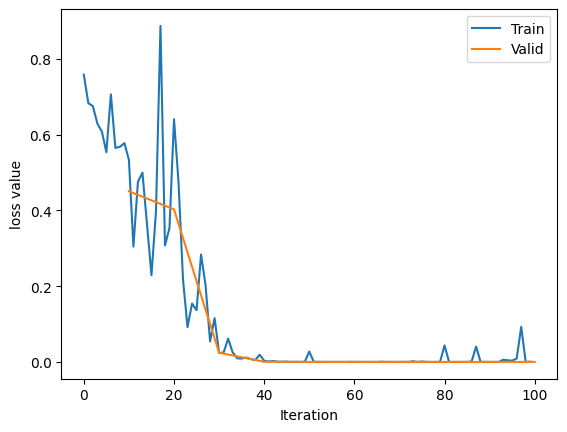

In [11]:
# ============================ inference ============================

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
test_dir = os.path.join(BASE_DIR, "test_data")

test_data = RMBDataset(data_dir=test_dir, transform=valid_transform)
valid_loader = DataLoader(dataset=test_data, batch_size=1)

for i, data in enumerate(valid_loader):
    # forward
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    rmb = 1 if predicted.numpy()[0] == 0 else 100
    print("模型获得{}元".format(rmb))

# 总结：数据读取机制

首先在 for 循环中遍历DataLoader。  

然后根据是否采用多进程，决定使用单进程或者多进程的DataLoaderIter。  

在DataLoaderIter里调用Sampler生成Index的 list。  

再调用DatasetFetcher根据index获取数据。  

在DatasetFetcher里会调用Dataset的__getitem__()方法获取真正的数据。这里获取的数据是一个 list，其中每个元素是 (img, label) 的元组。  

再使用 collate_fn()函数整理成一个 list，里面包含两个元素，分别是 img 和 label 的tenser。

<img src="img/PyTorch 数据读取流程图.png">